<a href="https://colab.research.google.com/github/cardstud/Complete-Python-3-Bootcamp/blob/master/module3-databackedassertions/LS_DS_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=38.58637443034404, mobile=True), User(purchased=False, time_on_site=566.0211291274117, mobile=False), User(purchased=False, time_on_site=55.434126355169546, mobile=True), User(purchased=True, time_on_site=259.032596554001, mobile=False), User(purchased=False, time_on_site=478.66549805442537, mobile=False), User(purchased=False, time_on_site=154.2572308376381, mobile=True), User(purchased=True, time_on_site=226.50813865925954, mobile=True), User(purchased=False, time_on_site=277.05421863702907, mobile=True), User(purchased=False, time_on_site=183.57172357126424, mobile=False), User(purchased=True, time_on_site=251.74227736688042, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,38.586374,True
1,False,566.021129,False
2,False,55.434126,True
3,True,259.032597,False
4,False,478.665498,False


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.265785677004182,5.653033026710122,6.291066512196847,8.609001854600509,8.642308697908684,8.886279636562001,8.957014007292452,9.041650131201385,9.10749113823329,9.230191167026916,9.570452909943208,9.679703957399788,9.68474613687032,9.751660091428622,9.790062362470687,10.75398020247805,10.874683208587566,11.477537888154242,11.515478386324654,11.537030198874291,12.012071961628228,12.274316824029789,12.315652038909732,12.705586713506953,12.850732407373556,12.85195148351014,12.86179488485238,12.969764271277462,13.168578613716276,13.740193967472036,14.161339971217359,14.420942671490378,14.610723290449103,14.63933202285223,14.943266445324417,15.040552804087657,15.237562949625998,15.531484522553932,15.604351728410979,16.889833285189,...,513.4619348298195,513.541704719313,516.4072665368233,518.811167446549,519.5595256152493,519.5970241310622,520.0951574094255,520.4011488944534,521.2033702108063,525.6209872129984,527.3416069233169,529.9169789947665,530.1421470042387,533.6799769560874,536.0130067511608,537.5224119167048,543.289644232563,545.7034176696532,547.4473255053813,548.2001315484981,549.4782459985057,550.800272539195,553.2177631735166,557.9153599093487,560.0917753006636,566.0211291274117,566.2349786617075,568.8401952868568,570.4168108716441,574.7753585759987,575.7114698528213,577.2894914338297,578.2960360495528,578.4811556316233,578.6462529219502,580.644621719894,593.2334654533042,596.5341638665454,598.4218412762222,598.7956975329272
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,0,1,0,1,1,1,1,0,...,1,1,1,1,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,0,1,0,0,0
True,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1


In [17]:
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 2.8MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.672, 123.972]","(123.972, 242.678]","(242.678, 361.384]","(361.384, 480.09]","(480.09, 598.796]"
purchased,,,,,
False,242,214,90,30,31
True,118,144,84,26,21


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.672, 123.972]","(123.972, 242.678]","(242.678, 361.384]","(361.384, 480.09]","(480.09, 598.796]"
purchased,,,,,
False,0.672222,0.597765,0.517241,0.535714,0.596154
True,0.327778,0.402235,0.482759,0.464286,0.403846


In [8]:
import pandas as pd
pd.__version__


'0.23.4'

In [0]:
pd.crosstab?

In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

In [11]:
pd.crosstab(user_data['purchased'], [time_bins, user_data['mobile']])

time_on_site (4.672, 123.972]        ...        (480.09, 598.796]
mobile                  False        ...                    False
purchased                            ...                         
False                      47        ...                       31
True                        8        ...                       21

[2 rows x 8 columns]

In [15]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.672, 123.972]    0.274854  0.447248  0.101266  0.350318
(123.972, 242.678]  0.216374  0.405963  0.126582  0.426752
(242.678, 361.384]  0.152047  0.146789  0.177215  0.222930
(361.384, 480.09]   0.175439  0.000000  0.329114  0.000000
(480.09, 598.796]   0.181287  0.000000  0.265823  0.000000

In [20]:
ct_subset= ct.iloc[:, [2,3]]
ct_subset

purchased               True          
mobile                 False     True 
time_on_site                          
(4.672, 123.972]    0.101266  0.350318
(123.972, 242.678]  0.126582  0.426752
(242.678, 361.384]  0.177215  0.222930
(361.384, 480.09]   0.329114  0.000000
(480.09, 598.796]   0.265823  0.000000

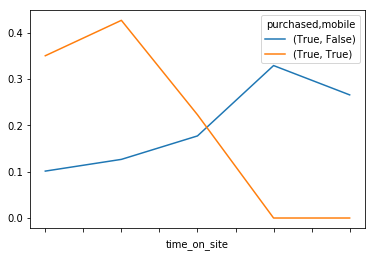

In [21]:
ct_subset.plot()

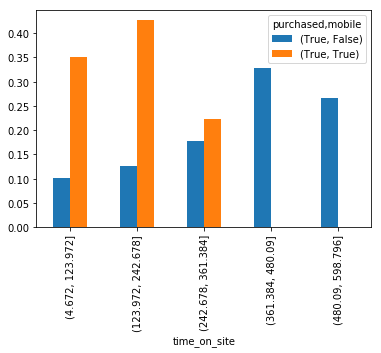

In [18]:
ct_subset.plot(kind='bar')

**MTL Bikepath** dataset

In [0]:
bike_data_url = 'https://raw.githubusercontent.com/jvns/pandas-cookbook/master/data/bikes.csv'

In [0]:
df = pd.read_csv(bike_data_url, sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')

In [26]:
df.head()

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN
2012-01-04,144,NaN,1,116,318,111,8,61,NaN
2012-01-05,197,NaN,2,124,330,97,13,95,NaN


In [27]:
!pip install unidecode

     |████████████████████████████████| 245kB 2.8MB/s 


In [29]:
import unidecode
new_cols=[unidecode.unidecode(col).lower() for col in df.columns]
new_cols

['berri 1',
 'brebeuf (donnees non disponibles)',
 'cote-sainte-catherine',
 'maisonneuve 1',
 'maisonneuve 2',
 'du parc',
 'pierre-dupuy',
 'rachel1',
 'st-urbain (donnees non disponibles)']

In [30]:
df.columns = new_cols
df.head()

,berri 1,brebeuf (donnees non disponibles),cote-sainte-catherine,maisonneuve 1,maisonneuve 2,du parc,pierre-dupuy,rachel1,st-urbain (donnees non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN
2012-01-04,144,NaN,1,116,318,111,8,61,NaN
2012-01-05,197,NaN,2,124,330,97,13,95,NaN


In [0]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

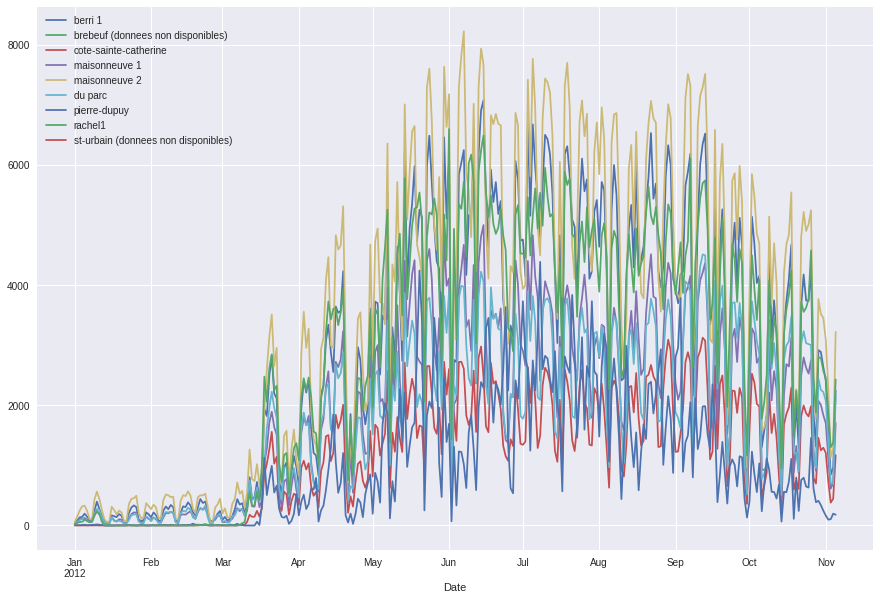

In [33]:
df.plot(figsize=(15,10))


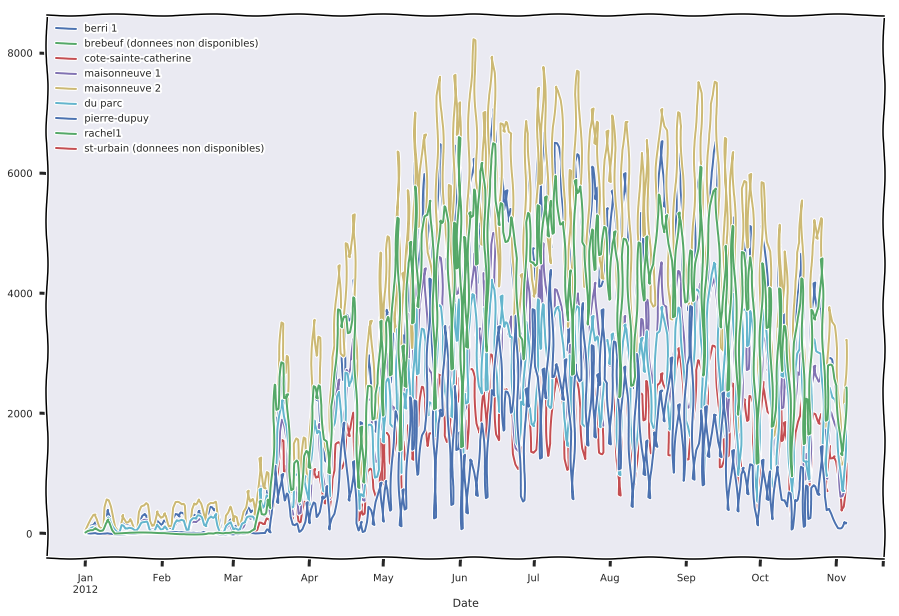

In [35]:
with plt.xkcd():
  df.plot(figsize=(15,10))

In [0]:
col = 'pierre-dupuy'
bike_path = df[[col]].copy()  # copy creates a copy of the object in memory different from original so changes do not affect original

In [39]:
bike_path

,berri 1
Date,
2012-01-01,35
2012-01-02,83
2012-01-03,135
2012-01-04,144
2012-01-05,197
2012-01-06,146
2012-01-07,98
2012-01-08,95
2012-01-09,244


In [51]:
bike_path.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2012-10-27', '2012-10-28', '2012-10-29', '2012-10-30',
               '2012-10-31', '2012-11-01', '2012-11-02', '2012-11-03',
               '2012-11-04', '2012-11-05'],
              dtype='datetime64[ns]', name='Date', length=310, freq=None)

In [52]:
bike_path.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            27, 28, 29, 30, 31,  1,  2,  3,  4,  5],
           dtype='int64', name='Date', length=310)

In [53]:
bike_path.index.weekday

Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
            ...
            5, 6, 0, 1, 2, 3, 4, 5, 6, 0],
           dtype='int64', name='Date', length=310)

In [0]:
# lets add a weekday column
bike_path.loc[:, 'weekday'] = bike_path.index.weekday

In [55]:
bike_path.head()

,pierre-dupuy,weekday
Date,,
2012-01-01,10,6
2012-01-02,6,0
2012-01-03,3,1
2012-01-04,8,2
2012-01-05,13,3


In [56]:
# Group by day and sum to get total bikers on this path for that day
weekday_counts = bike_path.groupby('weekday').aggregate(sum)
weekday_counts

,pierre-dupuy
weekday,
0,46204
1,35167
2,43263
3,45385
4,42470
5,52861
6,61485


In [57]:
# Change index to name of day
weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts

,pierre-dupuy
Monday,46204
Tuesday,35167
Wednesday,43263
Thursday,45385
Friday,42470
Saturday,52861
Sunday,61485


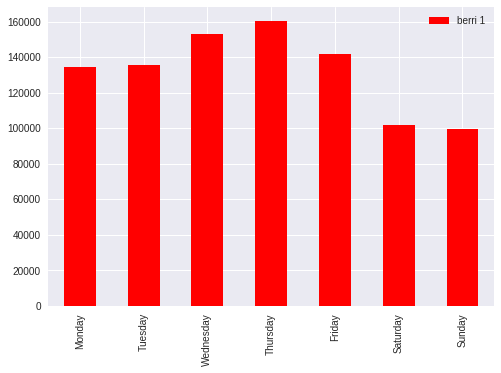

In [49]:
# create a bar plot
weekday_counts.plot(kind='bar', color='red')

In [0]:
# Look at other routes
# Look at times such as morning etc
col = 'pierre=dupuy'

In [59]:
weekday_counts['pierrer-dupuy'].max()

KeyError: ignored

Vancouver Crime Dataset

In [61]:
# https://data.vancouver.ca/datacatalogue/crime-data-attributes.htm
!wget ftp://webftp.Vancouver.ca/opendata/csv//crime_csv_all_years.zip

--2019-09-10 03:41:26--  ftp://webftp.vancouver.ca/opendata/csv//crime_csv_all_years.zip
           => ‘crime_csv_all_years.zip’
Resolving webftp.vancouver.ca (webftp.vancouver.ca)... 199.175.219.218
Connecting to webftp.vancouver.ca (webftp.vancouver.ca)|199.175.219.218|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /opendata/csv/ ... done.
==> SIZE crime_csv_all_years.zip ... done.

==> PASV ... done.    ==> RETR crime_csv_all_years.zip ... done.

crime_csv_all_years     [         <=>        ]   8.68M  4.89MB/s    in 1.8s    

2019-09-10 03:41:29 (4.89 MB/s) - ‘crime_csv_all_years.zip’ saved [9107123]



In [0]:
import zipfile
with zipfile.ZipFile('crime_csv_all_years.zip', 'r') as zip_ref:
  zip_ref.extractall('.')



In [63]:
df = pd.read_csv('crime_csv_all_years.csv')
df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Residential/Other,2003,12,7,21.0,30.0,36XX E 47TH AVE,Killarney,498148.47,5452617.84
1,Break and Enter Residential/Other,2003,2,9,18.0,0.0,16XX GRANT ST,Grandview-Woodland,494890.46,5457626.75
2,Theft from Vehicle,2003,1,8,11.0,45.0,19XX W 11TH AVE,Kitsilano,489121.18,5456575.35
3,Theft from Vehicle,2003,3,20,18.0,0.0,19XX VINE ST,Kitsilano,488546.95,5457304.88
4,Theft from Vehicle,2003,2,19,17.0,30.0,19XX VINE ST,Kitsilano,488546.95,5457304.88


In [64]:
df.shape

(613900, 10)

In [65]:
df['TYPE'].value_counts()

Theft from Vehicle                                        205502
Mischief                                                   82668
Break and Enter Residential/Other                          65737
Other Theft                                                63404
Offence Against a Person                                   61238
Theft of Vehicle                                           41170
Break and Enter Commercial                                 38328
Theft of Bicycle                                           30397
Vehicle Collision or Pedestrian Struck (with Injury)       24921
Vehicle Collision or Pedestrian Struck (with Fatality)       286
Homicide                                                     249
Name: TYPE, dtype: int64

In [66]:
df['TYPE'].value_counts(normalize=True)

Theft from Vehicle                                        0.334748
Mischief                                                  0.134660
Break and Enter Residential/Other                         0.107081
Other Theft                                               0.103281
Offence Against a Person                                  0.099752
Theft of Vehicle                                          0.067063
Break and Enter Commercial                                0.062434
Theft of Bicycle                                          0.049515
Vehicle Collision or Pedestrian Struck (with Injury)      0.040595
Vehicle Collision or Pedestrian Struck (with Fatality)    0.000466
Homicide                                                  0.000406
Name: TYPE, dtype: float64

In [69]:
df['TYPE'] == 'Theft from Vehicle'

0         False
1         False
2          True
3          True
4          True
5         False
6         False
7          True
8          True
9         False
10        False
11        False
12        False
13        False
14        False
15         True
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23         True
24        False
25        False
26         True
27        False
28        False
29        False
          ...  
613870    False
613871     True
613872     True
613873     True
613874     True
613875     True
613876    False
613877    False
613878    False
613879    False
613880     True
613881     True
613882    False
613883     True
613884     True
613885    False
613886     True
613887     True
613888     True
613889    False
613890    False
613891     True
613892    False
613893    False
613894    False
613895     True
613896    False
613897     True
613898     True
613899    False
Name: TYPE, Length: 6139

In [68]:
df[df['TYPE'] == 'Theft from Vehicle']  # now i pass in the boolean to the DF and i get back the subset where it is true--below

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
2,Theft from Vehicle,2003,1,8,11.0,45.0,19XX W 11TH AVE,Kitsilano,489121.18,5456575.35
3,Theft from Vehicle,2003,3,20,18.0,0.0,19XX VINE ST,Kitsilano,488546.95,5457304.88
4,Theft from Vehicle,2003,2,19,17.0,30.0,19XX VINE ST,Kitsilano,488546.95,5457304.88
7,Theft from Vehicle,2003,1,30,16.0,0.0,19XX VICTORIA DR,Grandview-Woodland,495217.31,5457218.96
8,Theft from Vehicle,2003,4,11,1.0,48.0,19XX VERNON DR,Strathcona,494267.38,5457234.70
15,Theft from Vehicle,2003,7,20,19.0,50.0,BURRARD ST / ROBSON ST,West End,491068.86,5458954.92
23,Theft from Vehicle,2003,7,17,20.0,0.0,BURRARD ST / ROBSON ST,West End,491068.86,5458954.92
26,Theft from Vehicle,2003,1,7,22.0,0.0,51XX SPENCER ST,Renfrew-Collingwood,497150.26,5453868.80
30,Theft from Vehicle,2003,5,16,20.0,0.0,BURRARD ST / ROBSON ST,West End,491068.86,5458954.92
32,Theft from Vehicle,2003,9,26,22.0,50.0,51XX SPENCER ST,Renfrew-Collingwood,497203.17,5453935.22


In [72]:
df[df['TYPE'] == 'Theft from Vehicle'].groupby('YEAR')['TYPE'].agg('count')

YEAR
2003    17744
2004    18204
2005    16554
2006    14734
2007    12226
2008    11298
2009    10007
2010     8612
2011     7435
2012     8097
2013     8341
2014    10140
2015    10546
2016    12815
2017    12960
2018    15002
2019    10787
Name: TYPE, dtype: int64

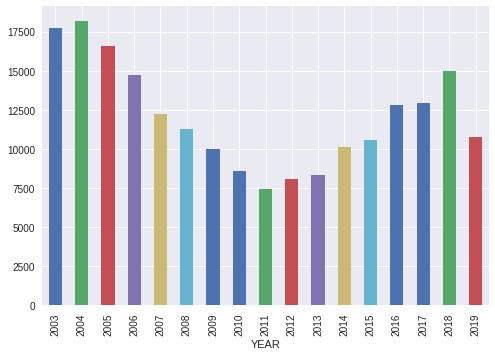

In [71]:
df[df['TYPE'] == 'Theft from Vehicle'].groupby('YEAR')['TYPE'].agg('count').plot(kind='bar')

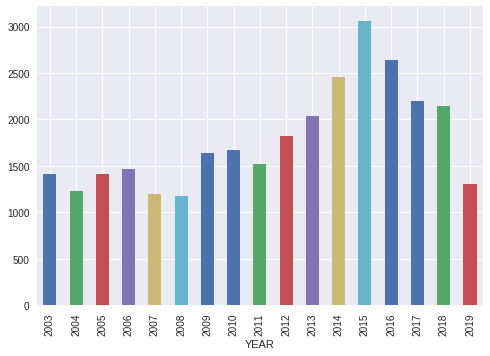

In [73]:
df[df['TYPE'] == 'Theft of Bicycle'].groupby('YEAR')['TYPE'].agg('count').plot(kind='bar')

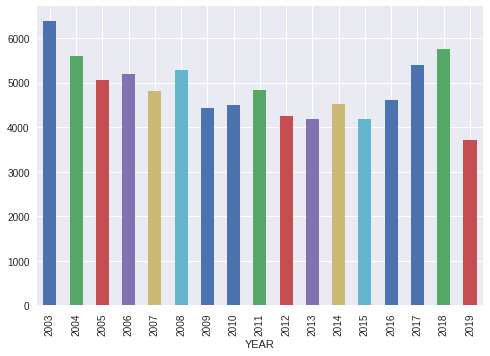

In [74]:
df[df['TYPE'] == 'Mischief'].groupby('YEAR')['TYPE'].agg('count').plot(kind='bar')

In [0]:
# Probably better to make a function since copy and pasting alot
def plot_crime_type_vs_year(col_name):
  df[df['TYPE'] == col_name].groupby('YEAR')['TYPE'].agg('count').plot(kind='bar')

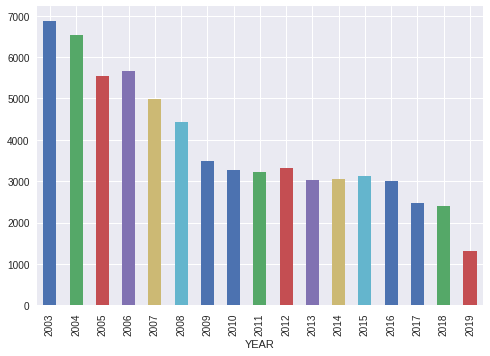

In [78]:
plot_crime_type_vs_year('Break and Enter Residential/Other')

In [0]:
# How to plot data points on a map



Plotting points on map (advanced)

In [0]:
import folium

In [80]:
! pip install utm


  Created wheel for utm: filename=utm-0.5.0-cp36-none-any.whl size=5903 sha256=32ae6197cf110e437dddc74eac2065bbb2c9b57b4ebf0c7c62687a54c64e2b15
  Stored in directory: /root/.cache/pip/wheels/22/85/c2/314ffed39b8e02ca623e9b7d2ad7fcf3f8544a0e77c096be76
Successfully built utm


In [0]:
import utm

In [84]:
def utm2wgs84(row):
  # create 2 new cols, lat and long, from x and y
  try:
    return pd.Series(utm.to_latlon(row['X'], row['Y'], 10, 'U'))   # converts utm coords to lat and lon
  # code will fail if any 0's so need to fix that
  except:
    return pd.Series((None, None))

df_bike_theft = df[['TYPE'] =='Theft of Bicycle'].copy()


KeyError: ignored

In [0]:
df_bike_theft.sample(5)

In [0]:
df_bike_theft[['lat', 'long']] df_bike_theft.apply(lambda row: utm2wgs84(row))

In [0]:
locations = df_bike_theft[['lat', 'long']]
locations_list = locations.tolist()
len(locations_list)